### Импорт данных

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.linalg import pinv

In [2]:
# импортируем данные
df = pd.read_csv(r"C:\Users\allek\OneDrive\Рабочий стол\summer_train\git_project\Diabetes-ML-From-Scratch\raw_data\diabetes.csv")

In [3]:
import sys
import os

# Добавляем папку src в путь поиска Python
sys.path.append(os.path.join(os.getcwd(), '..'))

# Теперь можно импортировать ваши модули
from src.data.cleaning import get_median, replacing_zero_values_median, get_quantiles, capping_outliers
from src.features.engineering import create_medical_features, one_hot_encoding
from src.data.scaling import get_params_for_standardization, standardization

### Разделение данных

In [4]:
# Предположим, что целевая переменная называется 'target'
X = df         #df.drop('Outcome', axis=1)  # Признаки
y = df['Outcome']               # Целевая переменная

# Разделение данных (80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    random_state=14,  # для воспроизводимости
    stratify=y        # для сохранения распределения целевой переменной
)

### Обработка данных для баейссовского классификатора.

In [5]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
# удаление данных, которые плохо кореллируют с целевой переменной
df = df.drop(['BloodPressure'], axis=1)

In [7]:
# заполнение пропусков
columns_insert_medians = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
medians = get_median(X_train, columns_insert_medians)

X_train = replacing_zero_values_median(X_train, columns_insert_medians, medians)
X_test = replacing_zero_values_median(X_test, columns_insert_medians, medians)

In [8]:
# capping(обрезание)
columns_capping = ['Pregnancies', 'SkinThickness', 'Insulin']
quantiles = [0.99] * 3
quantiles_values = get_quantiles(X_train, columns_capping, quantiles)
inequality = ['>'] * 3

X_train = capping_outliers(X_train, columns_capping, quantiles_values, inequality)
X_test = capping_outliers(X_test, columns_capping, quantiles_values, inequality)

In [9]:
# feature engineering

# Создание признаков на основе мед. знаний:
# инсулинорезистентность
X_train['HOMA_IR'] = (X_train['Glucose'] * X_train['Insulin']) / 22.5
X_test['HOMA_IR'] = (X_test['Glucose'] * X_test['Insulin']) / 22.5
# связь возраста и ожирения
X_train['BMI_AGE_BOND'] = X_train['Age'] * X_train['BMI']
X_test['BMI_AGE_BOND'] = X_test['Age'] * X_test['BMI']

In [10]:
X_train.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HOMA_IR,BMI_AGE_BOND
318,3.0,115.0,66.0,39.000000,140.000000,38.1,0.150,28,0,715.555556,1066.8
469,6.0,154.0,78.0,41.000000,140.000000,46.1,0.571,27,0,958.222222,1244.7
154,8.0,188.0,78.0,28.562334,163.450704,47.9,0.137,43,1,1365.721440,2059.7
755,1.0,128.0,88.0,39.000000,110.000000,36.5,1.057,37,1,625.777778,1350.5
599,1.0,109.0,38.0,18.000000,120.000000,23.1,0.407,26,0,581.333333,600.6


In [11]:
# standardization data
columns_get_mean_std = ['Pregnancies', 'SkinThickness', 'Insulin', 'DiabetesPedigreeFunction', 'Age', 'HOMA_IR', 'BMI_AGE_BOND', 'Glucose', 'BloodPressure', 'BMI']
standard_data = get_params_for_standardization(X_train, columns_get_mean_std)

X_train = standardization(X_train, standard_data)
X_test = standardization(X_test, standard_data)

In [12]:
display(X_train.describe())

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HOMA_IR,BMI_AGE_BOND
count,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,5.370000e+02,537.000000,5.370000e+02,5.370000e+02
mean,-3.307927e-17,3.241769e-16,-3.307927e-18,1.786281e-16,-6.615854e-18,-4.391273e-16,-1.422409e-16,-9.923781e-17,0.348231,-2.282470e-16,3.804116e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.476854,1.000000e+00,1.000000e+00
min,-1.140934e+00,-2.183684e+00,-3.879556e+00,-2.657393e+00,-1.810289e+00,-2.062033e+00,-1.191190e+00,-1.011205e+00,0.000000,-1.366875e+00,-1.590710e+00
25%,-8.398618e-01,-7.625562e-01,-6.732078e-01,-4.363450e-01,-4.498917e-01,-7.016070e-01,-7.016688e-01,-7.542972e-01,0.000000,-5.137393e-01,-7.595619e-01
50%,-2.377179e-01,-1.346162e-01,-3.193823e-02,3.216912e-03,2.184762e-02,-6.921684e-03,-2.614073e-01,-3.261179e-01,0.000000,-1.607661e-01,-1.840445e-01
75%,6.654980e-01,6.585712e-01,6.093313e-01,4.273958e-01,2.184762e-02,5.864554e-01,4.620995e-01,6.158765e-01,1.000000,2.200430e-01,6.312719e-01
max,2.773002e+00,2.509342e+00,3.975997e+00,2.525052e+00,4.319058e+00,5.015075e+00,5.739080e+00,3.356224e+00,1.000000,5.528652e+00,3.798480e+00


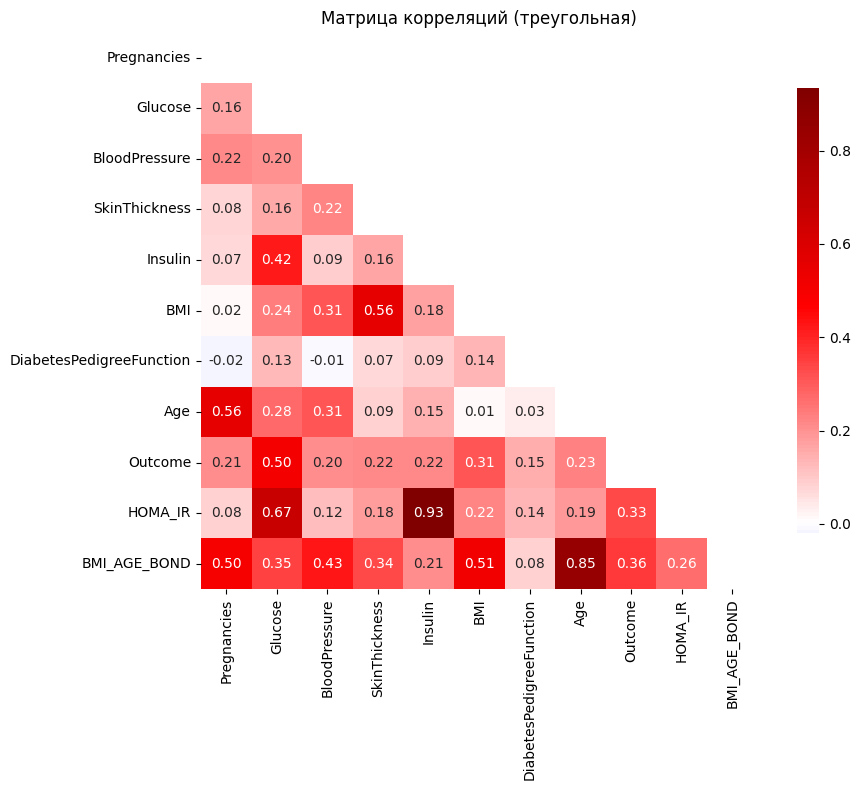

In [13]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))

# Маска для скрытия верхнего треугольника
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True,
            cmap='seismic',
            center=0,
            square=True,
            fmt='.2f',
            cbar_kws={"shrink": .8})

plt.title('Матрица корреляций (треугольная)')
plt.tight_layout()
plt.show()

### Реализация байессовского классификатора

In [14]:
# матрица ковариаций для классов
mask_positive = X_train['Outcome'] == 1
mask_negative = X_train['Outcome'] == 0

cov_matrix_positive = np.cov(X_train[mask_positive].drop(['Outcome'], axis=1), rowvar=False) + 1e-1 * np.eye(X_train.shape[1] - 1)
cov_matrix_negative = np.cov(X_train[mask_negative].drop(['Outcome'], axis=1), rowvar=False) + 1e-1 * np.eye(X_train.shape[1] - 1)

In [15]:
np.linalg.det(cov_matrix_negative)

np.float64(0.010633156793428517)

In [16]:
# значение медиан для признаков классов
mean_positive = X_train[mask_positive].drop(['Outcome'], axis=1).mean()
mean_negative = X_train[mask_negative].drop(['Outcome'], axis=1).mean()
X_train[mask_negative].describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,HOMA_IR,BMI_AGE_BOND
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000,350.0,350.000000,350.000000
mean,-0.152558,-0.366792,-0.149433,-0.157244,-0.158487,-0.228978,-0.112994,-0.166835,0.0,-0.243497,-0.261221
std,0.896288,0.817085,0.967567,1.005276,0.905239,0.945088,0.938886,0.997226,0.0,0.821774,0.944163
min,-1.140934,-2.183684,-3.879556,-2.657393,-1.810289,-2.062033,-1.191190,-1.011205,0.0,-1.366875,-1.590710
25%,-0.839862,-0.927804,-0.833525,-0.806520,-0.777395,-0.980205,-0.760165,-0.839933,0.0,-0.728955,-0.974683
50%,-0.538790,-0.448586,-0.192256,0.003217,0.021848,-0.238483,-0.392254,-0.583026,0.0,-0.332491,-0.494503
75%,0.364426,0.096730,0.449014,0.304004,0.021848,0.394693,0.261981,0.251924,0.0,-0.045380,0.184210
max,2.773002,2.443243,3.975997,2.525052,4.319058,3.596759,5.739080,3.356224,0.0,5.528652,3.798480


In [17]:
argmax_y = lambda x, mm, cov, L, Py: np.log(L*Py) - 0.5 * np.sum((x-mm) @ pinv(cov) * (x-mm), axis=1) - 0.5*np.log(np.linalg.det(cov))

In [18]:
L1, L2 = 1, 1
Py1, Py2 = 0.5, 0.5

In [19]:
probable_positive = argmax_y(X_test.drop(['Outcome'], axis=1), mean_positive, cov_matrix_positive, L1, Py1)
probable_negative = argmax_y(X_test.drop(['Outcome'], axis=1), mean_negative, cov_matrix_negative, L2, Py2)

prediction = np.argmax([probable_positive, probable_negative], axis=0)

In [20]:
prediction

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])